## Setup

In [2]:
# Install packages and frameworks

import tensorflow as tf
import os
import visualkeras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from keras.utils import plot_model
from keras.callbacks import CSVLogger

# expecting 2.11
# if 2.7, than logging errors will show "Cleanup called..."
print(tf.__version__)

2023-06-01 23:02:20.409381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 23:02:20.529253: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-01 23:02:21.491605: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-01 23:02:21.491715: W tensorflow/

2.11.1


In [77]:
# manually set a filename to store and compare reports
os.environ['FILENAME'] = 'train_tune'

In [3]:
# scratch directory is apart of the .gitignore to ensure it is not committed to git
%env SCRATCH=../scratch
! [ -e "${SCRATCH}" ] || mkdir -p "${SCRATCH}"

scratch_path = os.environ.get('SCRATCH', './scratch')

env: SCRATCH=../scratch


# Load the saved datasets

The TFRecord format is a simple format for storing a sequence of binary records.

## Load train

In [4]:
path = scratch_path + '/tf_datasets/train/'
train_ds = tf.data.Dataset.load(path)
train_ds.element_spec

2023-06-01 23:02:23.732089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 23:02:23.761151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 23:02:23.764044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 23:02:23.767208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))

## Load validate

In [5]:
path = scratch_path + '/tf_datasets/validate/'
validation_ds = tf.data.Dataset.load(path)
validation_ds.element_spec

(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))

## Load test

In [6]:
path = scratch_path + '/tf_datasets/test/'
test_ds = tf.data.Dataset.load(path)
test_ds.element_spec

(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))

## Apply augmentation

When you don't have a large image dataset or when your images are all set in a single direction like ours are, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce over-fitting. 

Learn more https://www.tensorflow.org/tutorials/images/data_augmentation

## Configure the datasets for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

1. `Caching` a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.
1. `Prefetching` overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

[Optimising your input pipeline performance with tf.data (part 1)](https://towardsdatascience.com/optimising-your-input-pipeline-performance-with-tf-data-part-1-32e52a30cac4)

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Check the device spec

In [17]:
# display physical devices
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Create the model

## Set some variables

In [18]:
# set variables for consistency
img_height = 96              # desired height
img_width = 96               # desired width
batch_size = 32              # batch inputs in 32
seed_train_validation = 42   # Must be same for train_ds and val_ds
validation_split = 0.3       # move 30% of the data into validation
class_names = ['left', 'right']

dataFormat="channels_last"
num_classes = len(class_names)
inputShape=(img_height, img_width, 1)
chanDim = -1

## Define a model and hyperparameters

When you build a model for hypertuning, you also define the hyperparameter search space in addition to the model architecture. The model you set up for hypertuning is called a hypermodel.

In [58]:
# build model from scratch
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout,Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import layers
from tensorflow import keras
import keras_tuner as kt

num_classes = len(class_names)

inputShape=(img_height, img_width, 1)
data_format="channels_last"

def model_builder(hp):
    model = keras.Sequential(name="fingerprint_prediction")
    # comment out to remove augmentation
    #data_augmentation
    input_shape=(img_height, img_width, 1)
    chanDim = -1
    # first CONV => RELU => POOL layer set
    model.add(Conv2D(
        hp.Int("conv_1", min_value=32, max_value=96, step=32),
        (3, 3), padding="same", input_shape=inputShape, data_format=data_format))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # second CONV => RELU => POOL layer set
    model.add(Conv2D(
        hp.Int("conv_2", min_value=64, max_value=128, step=32),
        (3, 3), padding="same", data_format=data_format))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # third CONV => RELU => POOL layer set
    model.add(Conv2D(
        hp.Int("conv_3", min_value=96, max_value=256, step=32),
        (3, 3), padding="same", data_format=data_format))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(hp.Int("dense_units", min_value=256,
                           max_value=768, step=256)))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # softmax classifier
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))
    
    # initialize the learning rate choices and optimizer
    lr = hp.Choice("learning_rate",
                   values=[1e-1, 1e-2, 1e-3])
    # compile the model
    model.compile(optimizer='adam', loss="categorical_crossentropy",
                  metrics=["accuracy"])
    # return the model
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.losses.CategoricalCrossentropy(from_logits=False),
        # metrics to be evaluated by the model during training and testing.The strings 'accuracy' or 'acc', TF converts this to binary, categorical or sparse.
        metrics=['accuracy'],
    )
    return model

## Define a training strategy 

tf.distribute.Strategy is a TensorFlow API to distribute training across multiple GPUs, multiple machines, or TPUs. Using this API, you can distribute your existing models and training code with minimal code changes.
- Easy to use and support multiple user segments, including researchers, machine learning engineers, etc.
- Provide good performance out of the box.
- Easy switching between strategies.

In [59]:
# display logical devices
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

### One Device Strategy

A distribution strategy for running on a single device. Device string identifier for the device on which the variables should be placed.

In [60]:
# uncomment to create a OneDeviceStrategy
#strategy = tf.distribute.OneDeviceStrategy(device=device)

### Mirrored Strategy 

Supports synchronous distributed training on multiple GPUs on one machine. It creates one replica per GPU device. Each variable in the model is mirrored across all the replicas. 

In [61]:
# uncomment to create a MirroredStrategy

#strategy = tf.distribute.MirroredStrategy(devices=device)

### Multi-Worker Mirrored Strategy

Multi-Worker MirroredStrategy is very similar to MirroredStrategy. It implements synchronous distributed training across multiple workers, each with potentially multiple GPUs. Similar to tf.distribute.MirroredStrategy, it creates copies of all variables in the model on each device across all workers.

MultiWorkerMirroredStrategy has two implementations for cross-device communications. 
1. CommunicationImplementation.RING is RPC-based and supports both CPUs and GPUs. 
1. CommunicationImplementation.NCCL uses NCCL and provides state-of-art performance on GPUs but it doesn't support CPUs. 
1. CollectiveCommunication.AUTO defers the choice to Tensorflow. 

You can specify them in the following way:

In [62]:
# uncomment to create a Multi-worker Mirrored Strategy

#communication_options = tf.distribute.experimental.CommunicationOptions(
    # RING is RPC-based and supports both CPUs and GPUs.
    #implementation=tf.distribute.experimental.CommunicationImplementation.RING)

    # NCCL uses NCCL and provides state-of-art performance on GPUs but it doesn't support CPUs
    #implementation=tf.distribute.experimental.CommunicationImplementation.NCCL)
    
    # AUTO defers the choice to Tensorflow.
    #implementation=tf.distribute.experimental.CommunicationImplementation.AUTO)

#strategy = tf.distribute.MultiWorkerMirroredStrategy(communication_options=communication_options)

## Search hyperparameters

The Keras Tuner has four tuners available:
1. RandomSearch
1. Hyperband
1. BayesianOptimization
1. Sklearn. 

In this tutorial, you use the Hyperband tuner. 

The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. 

To instantiate the Hyperband tuner, you must specify the hypermodel, the objective to optimize and the maximum number of epochs to train (max_epochs).

In [63]:
num_classes = len(class_names)

# open a strategy scope
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    # Integer, the maximum number of epochs to train one model. It is recommended to set this to a value slightly higher than the expected epochs to convergence for your largest Model, and to use early stopping during training
    max_epochs=5,
    # Integer, the reduction factor for the number of epochs and number of models for each bracket. Defaults to 3.
    factor=3,
    # training strategy
    #distribution_strategy=strategy,
    # directory to save the hyperparameter trials
    # TODO Update with a variable
    directory=scratch_path + '/tune/model_hp',
    # folder to save the hyperparameter trail outputs
    project_name='hypertune',
    #  If you re-run the hyperparameter search, the Keras Tuner uses the existing state from these logs to resume the search. 
    # To disable this behavior, pass an additional overwrite=True argument while instantiating the tuner.
    overwrite=True
)

We’ll be using EarlyStopping to short circuit hyperparameter trials that are not performing well. Keep in mind that tuning hyperparameters is an extremely computationally expensive process, so if we can kill off poorly performing trials, we can save ourselves a bunch of time.

In [64]:
# stop training when a monitored metric has stopped improving
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode="auto")

This search will run for 10 Trials.
- CPU: Best val_accuracy: 0.947070837020874  | Total elapsed time: 02h 11m 29s | Model: ?
- GPU: Best val_accuracy: 0.872768342494964  | Total elapsed time: 00h 08m 44s | Sagemaker - Instance Type: ?
- GPU: Best val_accuracy: 0.879129886627197  | Total elapsed time: 00h 59m 48s | Model: Tesla M10 (x4) | Driver Version: 525.60.13  |  CUDA Version: 12.0

One a g4dn.16xlarge the learned values will be around: 

```
[INFO] optimal number of filters in conv_1 layer: 96
[INFO] optimal number of filters in conv_2 layer: 64
[INFO] optimal number of filters in conv_3 layer: 256
[INFO] optimal number of units in dense layer: 768
[INFO] optimal learning rate: 0.0010
```

In [65]:
tuner.search(train_ds, epochs=4, validation_data=validation_ds, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("[INFO] optimal number of filters in conv_1 layer: {}".format(
	best_hps.get("conv_1")))
print("[INFO] optimal number of filters in conv_2 layer: {}".format(
	best_hps.get("conv_2")))
print("[INFO] optimal number of filters in conv_3 layer: {}".format(
	best_hps.get("conv_3")))
print("[INFO] optimal number of units in dense layer: {}".format(
	best_hps.get("dense_units")))
print("[INFO] optimal learning rate: {:.4f}".format(
	best_hps.get("learning_rate")))

Trial 10 Complete [00h 00m 45s]
val_accuracy: 0.8891570568084717

Best val_accuracy So Far: 0.8891570568084717
Total elapsed time: 00h 05m 28s
INFO:tensorflow:Oracle triggered exit
[INFO] optimal number of filters in conv_1 layer: 64
[INFO] optimal number of filters in conv_2 layer: 64
[INFO] optimal number of filters in conv_3 layer: 160
[INFO] optimal number of units in dense layer: 512
[INFO] optimal learning rate: 0.0010


## Fit a model

Fit the model with the optimal hyperparameters and train it on the data for a desired number of epochs. This training cycle will run for 9 epochs resulting in an accuracy around ~0.98 accuracy

In [66]:
epochs = 8

filename = '../reports/' + filename + '-score.csv'
csv_logger = CSVLogger(filename, append=True, separator=';')

model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=validation_ds,
    epochs=epochs,
    workers=1,
    use_multiprocessing=False,
    callbacks=[csv_logger]
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/8
393/393 [==============================] - 11s 22ms/step - loss: 0.4049 - accuracy: 0.8328 - val_loss: 2.1905 - val_accuracy: 0.6740
Epoch 2/8
393/393 [==============================] - 8s 21ms/step - loss: 0.3330 - accuracy: 0.8587 - val_loss: 0.2611 - val_accuracy: 0.8871
Epoch 3/8
393/393 [==============================] - 8s 21ms/step - loss: 0.2796 - accuracy: 0.8825 - val_loss: 1.6427 - val_accuracy: 0.6001
Epoch 4/8
393/393 [==============================] - 8s 21ms/step - loss: 0.2278 - accuracy: 0.9045 - val_loss: 0.4913 - val_accuracy: 0.7991
Epoch 5/8
393/393 [==============================] - 8s 21ms/step - loss: 0.1954 - accuracy: 0.9180 - val_loss: 0.7477 - val_accuracy: 0.7714
Epoch 6/8
393/393 [==============================] - 8s 21ms/step - loss: 0.1558 - accuracy: 0.9387 - val_loss: 0.6312 - val_accuracy: 0.8028
Epoch 7/8
393/393 [==============================] - 8s 21ms/step - loss: 0.1086 - accuracy: 0.9578 - val_loss: 0.7556 - val_accuracy: 0.8058
Epoch

### Visualize the model architecture

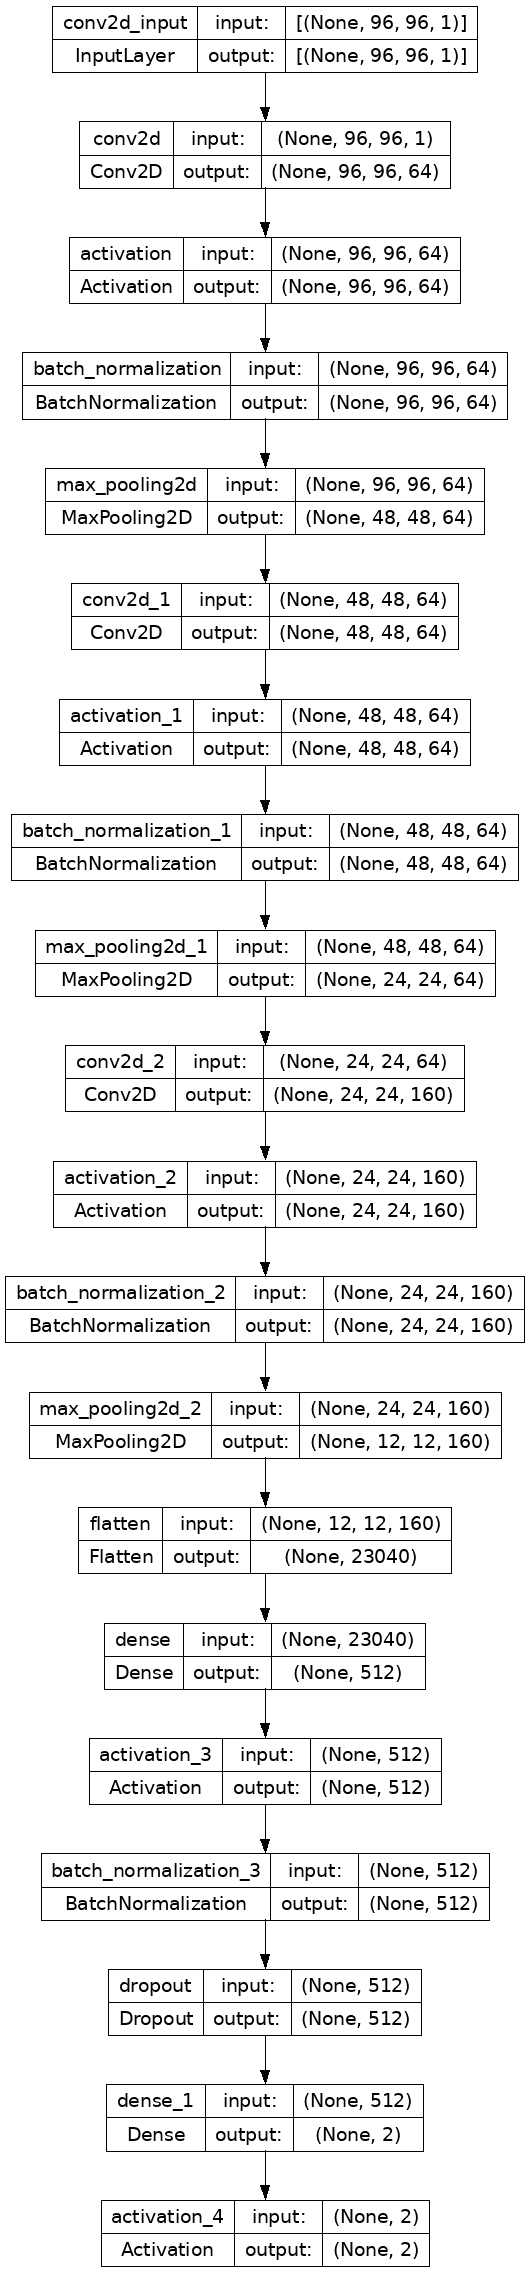

In [67]:
# Plot the resulting model architecture: https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model
filename = os.getenv('FILENAME')

to_file='../reports/' + filename + '_model_plot.png'
tf.keras.utils.plot_model(model, show_shapes=True,to_file=to_file)

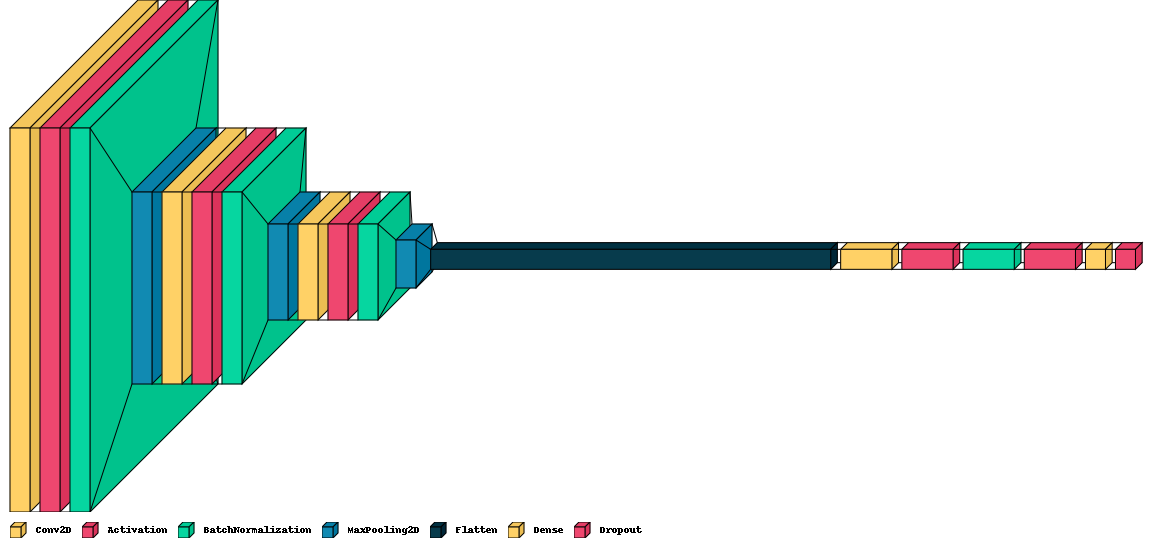

In [68]:
# Visualize the model
to_file='../reports/' + filename + '_model_visual.png'
visualkeras.layered_view(model, legend=True, draw_volume=True, to_file=to_file)

# Evaluate the model

Next, compare how the model performs on the test dataset:

In [69]:
model.evaluate(
    test_ds,
    batch_size=batch_size,
    verbose='auto',
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

169/169 [==============================] - 1s 6ms/step - loss: 0.5750 - accuracy: 0.8288


[0.5749785304069519, 0.8288154602050781]

# Score the model

In [70]:
# Generate generalization metrics
score = model.evaluate(test_ds, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.5749785304069519 / Test accuracy: 0.8288154602050781


# Save the model

A SavedModel is a directory containing serialized signatures and the state needed to run them, including variable values and vocabularies.

```
assets            directory contains files used by the TensorFlow graph
keras_metadata.pb file  
saved_model.pb    file stores the actual TensorFlow program, or model, and a set of named signatures for tensor I/O
variables         directory contains a standard training checkpoint 
```

There are 2 formats you can use to save an entire model to disk, the TensorFlow SavedModel format and the older Keras H5 format.

For versioning, you typically generate several models made up of (code, data, config) that demands model versioning. 

`/parent-folder/project-name/VERSION_NUMBER/MAJOR.MINOR.PIPELINE.tf`

Triton expects the following folder structure:

`/parent-folder/project-name/VERSION_NUMBER/model.savedmodel`

* `parent-folder` should be the root of s3 url, ex: `s3://bucket/parent-folder`

In [83]:
# note: tf.saved_model.save(model, path_to_dir)
model_path = "../models/fingerprint/" + "1" + "/model.savedmodel"
model.save(model_path)

INFO:tensorflow:Assets written to: ../models/fingerprint/1/model.savedmodel/assets


INFO:tensorflow:Assets written to: ../models/fingerprint/1/model.savedmodel/assets
